# Import libraries

In [1]:
import kagglehub
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchsummary import summary

# Data Preprocessing

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Download dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [3]:
dataset_dir = r'C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2'

# List all files and directories in the dataset folder
for root, dirs, files in os.walk(dataset_dir):
    print(f"Directory: {root}")

Directory: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2
Directory: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray
Directory: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray
Directory: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\test
Directory: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\test\NORMAL
Directory: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\test\PNEUMONIA
Directory: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\train
Directory: C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\tra

In [5]:
# Preprocessing for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                            # Resize images to 224x224
    transforms.RandomHorizontalFlip(p = 0.5),                 # Randomly flip images horizontally
    transforms.RandomRotation(degrees = 15),                  # Randomly rotate images up to ±15 degrees
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),  # Adjust brightness and contrast randomly
    transforms.ToTensor(),                                     # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])                # Normalize with mean and std
])

# Preprocessing for the validation and testing dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize images to 224x224
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean = [0.5], std = [0.5])   # Normalization
])

# Define path
dataset_dir = r"C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# load data according to the train, validation and test dataset, continue with preprocessing step
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Model

In [20]:
from torchvision.models import vgg16, resnet50, densenet121

def load_vgg16_model():
    model = vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(4096, 2)  
    return model.to(device)

def load_resnet50_model():
    model = resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  
    return model.to(device)

def load_densenet121_model():
    model = densenet121(pretrained=True)  
    num_features = model.classifier.in_features     
    model.classifier = nn.Linear(num_features, 2)   
    return model.to(device)


In [21]:
vgg16_model = load_vgg16_model()
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
summary(vgg16_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [22]:
resnet50_model = load_resnet50_model()
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
summary(resnet50_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [23]:
densenet121_model = load_densenet121_model()
print(densenet121_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Define Training and Evaluation Step

In [30]:
def train_model(model, train_loader, val_loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Accuracy calculation for training
            _, predicted = torch.max(outputs, 1)                # Get the class with max probability
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation phase
        model.eval()          
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                
                # Accuracy calculation for validation
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        
        # Print losses and accuracies
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    print("Training Complete!")

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())      # Store predictions
            all_labels.extend(labels.cpu().numpy())    # Store ground truth labels
    
    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {accuracy:.4f}")

    # F1 Score
    f1 = f1_score(all_labels, all_preds)
    print(f"F1 Score: {f1:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

---

# VGG16

In [12]:
# Train VGG16
train_model(vgg16_model, train_loader, val_loader, epochs=5)

Epoch [1/5], Train Loss: 0.2005, Train Accuracy: 0.9168, Validation Loss: 0.1622, Validation Accuracy: 1.0000
Epoch [2/5], Train Loss: 0.1017, Train Accuracy: 0.9641, Validation Loss: 0.3375, Validation Accuracy: 0.7500
Epoch [3/5], Train Loss: 0.0731, Train Accuracy: 0.9758, Validation Loss: 0.2735, Validation Accuracy: 0.8750
Epoch [4/5], Train Loss: 0.0559, Train Accuracy: 0.9801, Validation Loss: 0.0931, Validation Accuracy: 0.9375
Epoch [5/5], Train Loss: 0.0490, Train Accuracy: 0.9847, Validation Loss: 0.3166, Validation Accuracy: 0.8750
Training Complete!



Accuracy: 0.8654
F1 Score: 0.9026

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.65      0.78       234
   Pneumonia       0.82      1.00      0.90       390

    accuracy                           0.87       624
   macro avg       0.91      0.82      0.84       624
weighted avg       0.89      0.87      0.86       624



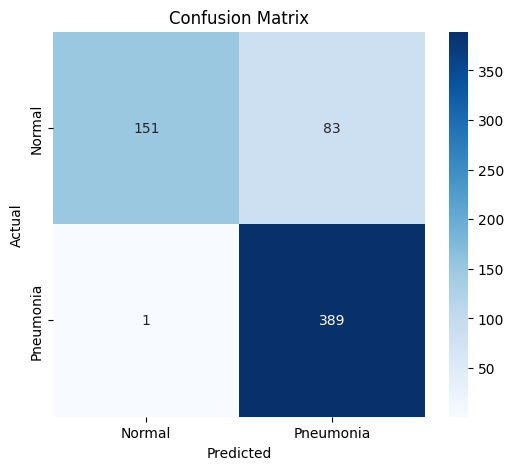

In [13]:
evaluate_model(vgg16_model, test_loader)

---

# ResNet50

In [21]:
# Train ResNet50 model
train_model(resnet50_model, train_loader, val_loader, epochs=5)

Epoch [1/5], Train Loss: 0.0113, Train Accuracy: 0.9958, Validation Loss: 1.5113, Validation Accuracy: 0.6875
Epoch [2/5], Train Loss: 0.0194, Train Accuracy: 0.9927, Validation Loss: 0.8332, Validation Accuracy: 0.6250
Epoch [3/5], Train Loss: 0.0109, Train Accuracy: 0.9956, Validation Loss: 0.0721, Validation Accuracy: 1.0000
Epoch [4/5], Train Loss: 0.0151, Train Accuracy: 0.9950, Validation Loss: 0.6614, Validation Accuracy: 0.7500
Epoch [5/5], Train Loss: 0.0106, Train Accuracy: 0.9960, Validation Loss: 0.3463, Validation Accuracy: 0.9375
Training Complete!


In [22]:
# Save the model
torch.save(resnet50_model.state_dict(), "resnet50_model_final.pth")
print("Model saved!")

Model saved!



Accuracy: 0.9215
F1 Score: 0.9394

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.83      0.89       234
   Pneumonia       0.91      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



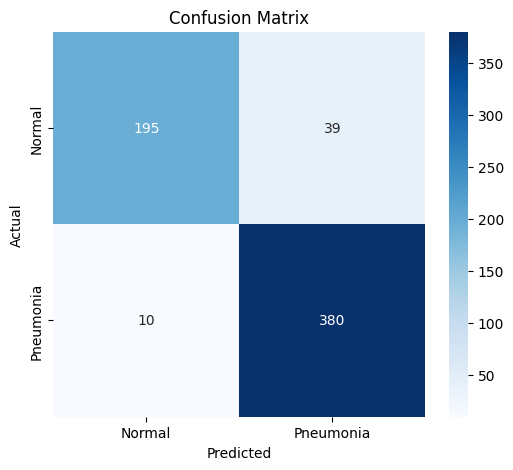

In [23]:
evaluate_model(resnet50_model, test_loader)

---

# DenseNet121

In [11]:
# Train DenseNet121 Model
train_model(densenet121_model, train_loader, val_loader, epochs=5)

Epoch [1/5], Train Loss: 0.1252, Train Accuracy: 0.9544, Validation Loss: 0.1032, Validation Accuracy: 1.0000
Epoch [2/5], Train Loss: 0.0614, Train Accuracy: 0.9791, Validation Loss: 0.2525, Validation Accuracy: 0.8125
Epoch [3/5], Train Loss: 0.0542, Train Accuracy: 0.9804, Validation Loss: 0.0426, Validation Accuracy: 1.0000
Epoch [4/5], Train Loss: 0.0417, Train Accuracy: 0.9866, Validation Loss: 0.1404, Validation Accuracy: 0.9375
Epoch [5/5], Train Loss: 0.0345, Train Accuracy: 0.9879, Validation Loss: 0.0859, Validation Accuracy: 0.9375
Training Complete!



Accuracy: 0.8622
F1 Score: 0.9002

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.64      0.78       234
   Pneumonia       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



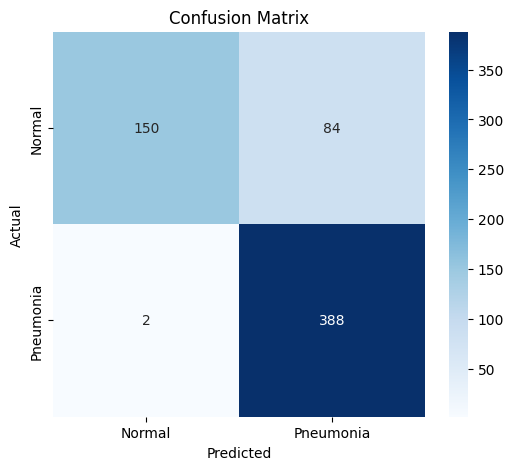

In [12]:
evaluate_model(densenet121_model, test_loader)

---

# Try to balanced the dataset, find out which model can get better result

In [14]:
# try to balanced the dataset, find out which model can get better result

# Preprocessing for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                            # Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),                  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=10),                   # Randomly rotate images up to ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),     # Adjust brightness and contrast randomly
    transforms.ToTensor(),                                    # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])              # Normalize with mean and std
])

# Preprocessing for the validation and testing dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize images to 224x224
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])       # Normalize
])

# Define path
dataset_dir = r"C:\Users\jiayi\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# Load datasets with transformations
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Specify class indices
minority_class_idx = 0  
majority_class_idx = 1  

# Split TRAINING minority and majority class samples
minority_class_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == minority_class_idx]
majority_class_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label == majority_class_idx]
print(f"Train minority_class_indices: {len(minority_class_indices)}")
print(f"Train majority_class_indices: {len(majority_class_indices)}")

# Downsample majority class in train dataset
sampled_majority_indices = torch.utils.data.RandomSampler(majority_class_indices, replacement=False, num_samples=len(minority_class_indices))
minority_samples = Subset(train_dataset, minority_class_indices)
sampled_majority_samples = Subset(train_dataset, sampled_majority_indices)

# Combine to create a balanced dataset
balanced_indices = list(minority_samples.indices) + list(sampled_majority_samples.indices)
balanced_train_dataset = Subset(train_dataset, balanced_indices)
print(f"Balanced training dataset size: {len(balanced_train_dataset)}")

# Split VALIDATION minority and majority class samples
minority_class_indices = [i for i, (_, label) in enumerate(val_dataset.samples) if label == minority_class_idx]
majority_class_indices = [i for i, (_, label) in enumerate(val_dataset.samples) if label == majority_class_idx]
print(f"Val minority_class_indices: {len(minority_class_indices)}")
print(f"Val majority_class_indices: {len(majority_class_indices)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Split TESTING minority and majority class samples
majority_test_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == majority_class_idx]
minority_test_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label == minority_class_idx]
print(f"Test minority_class_indices: {len(minority_test_indices)}")
print(f"Test majority_class_indices: {len(majority_test_indices)}")

# Downsample majority class in test dataset
balanced_test_indices = minority_test_indices + list(np.random.choice(majority_test_indices, len(minority_test_indices), replace=False))
balanced_test_dataset = Subset(test_dataset, balanced_test_indices)
print(f"Balanced test dataset size: {len(balanced_test_dataset)}")

# Create data loaders
train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(balanced_test_dataset, batch_size=32, shuffle=False)

Train minority_class_indices: 1341
Train majority_class_indices: 3875
Balanced training dataset size: 2682
Val minority_class_indices: 8
Val majority_class_indices: 8
Validation dataset size: 16
Test minority_class_indices: 234
Test majority_class_indices: 390
Balanced test dataset size: 468


---

# VGG16 with balance dataset

In [41]:
# Train vgg16 Model
train_model(vgg16_model, train_loader, val_loader, epochs=3)

Epoch [1/3], Train Loss: 0.2047, Train Accuracy: 0.9243, Validation Loss: 0.0887, Validation Accuracy: 1.0000
Epoch [2/3], Train Loss: 0.1174, Train Accuracy: 0.9623, Validation Loss: 0.0303, Validation Accuracy: 1.0000
Epoch [3/3], Train Loss: 0.0772, Train Accuracy: 0.9765, Validation Loss: 0.0127, Validation Accuracy: 1.0000
Training Complete!


In [42]:
# Save the model
torch.save(vgg16_model.state_dict(), "vgg16_model_final_balanced.pth")
print("Model saved!")

Model saved!



Accuracy: 0.8739
F1 Score: 0.8845

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.78      0.86       234
   Pneumonia       0.82      0.97      0.88       234

    accuracy                           0.87       468
   macro avg       0.89      0.87      0.87       468
weighted avg       0.89      0.87      0.87       468



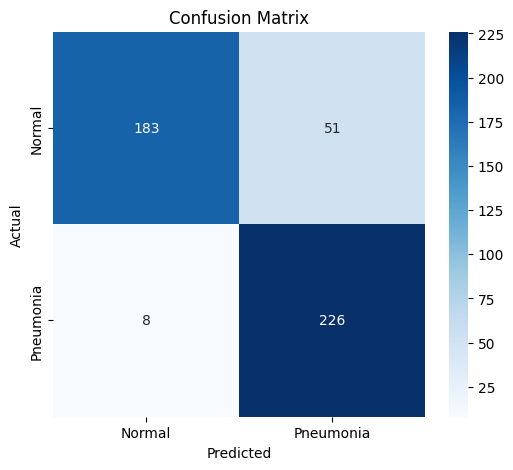

In [43]:
evaluate_model(vgg16_model, test_loader)

---

# ResNet50 with balance dataset

In [53]:
# Train ResNet50 model
train_model(resnet50_model, train_loader, val_loader, epochs=3)

Epoch [1/3], Train Loss: 0.0154, Train Accuracy: 0.9940, Validation Loss: 0.1517, Validation Accuracy: 0.8750
Epoch [2/3], Train Loss: 0.0203, Train Accuracy: 0.9929, Validation Loss: 0.0036, Validation Accuracy: 1.0000
Epoch [3/3], Train Loss: 0.0112, Train Accuracy: 0.9974, Validation Loss: 0.0092, Validation Accuracy: 1.0000
Training Complete!


In [54]:
# Save the model
torch.save(resnet50_model.state_dict(), "resnet50_model_final_balanced.pth")
print("Model saved!")

Model saved!



Accuracy: 0.8974
F1 Score: 0.9062

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.80      0.89       234
   Pneumonia       0.83      0.99      0.91       234

    accuracy                           0.90       468
   macro avg       0.91      0.90      0.90       468
weighted avg       0.91      0.90      0.90       468



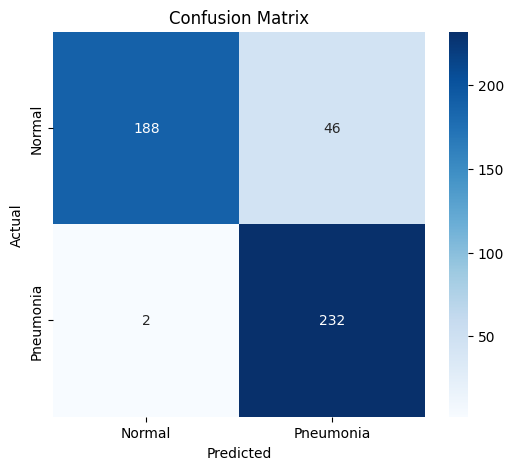

In [55]:
evaluate_model(resnet50_model, test_loader)

---

# DenseNet121 with balance dataset

In [50]:
# Train DenseNet121 Model
train_model(densenet121_model, train_loader, val_loader, epochs=3)

Epoch [1/3], Train Loss: 0.0205, Train Accuracy: 0.9929, Validation Loss: 0.0560, Validation Accuracy: 1.0000
Epoch [2/3], Train Loss: 0.0209, Train Accuracy: 0.9933, Validation Loss: 0.0138, Validation Accuracy: 1.0000
Epoch [3/3], Train Loss: 0.0147, Train Accuracy: 0.9952, Validation Loss: 0.0091, Validation Accuracy: 1.0000
Training Complete!


In [51]:
# Save the model
torch.save(densenet121_model.state_dict(), "densenet121_model_final_balanced.pth")
print("Model saved!")

Model saved!



Accuracy: 0.8697
F1 Score: 0.8829

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.76      0.85       234
   Pneumonia       0.80      0.98      0.88       234

    accuracy                           0.87       468
   macro avg       0.89      0.87      0.87       468
weighted avg       0.89      0.87      0.87       468



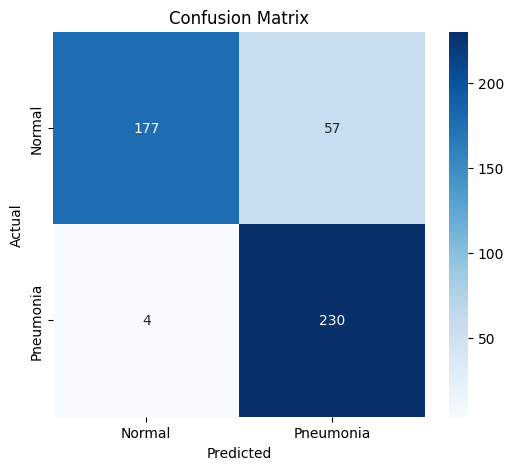

In [52]:
evaluate_model(densenet121_model, test_loader)

---

# XAI method

In [20]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from scipy.ndimage import gaussian_filter
from lime import lime_image

# Load the trained model
model_path = 'resnet50_model_final.pth'
model = models.resnet50(weights=None) # Initialized with random weights
model.fc = torch.nn.Linear(2048, 2)  # Replaces the final layer with a 2-output layer
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)) 
model.eval() # Sets the model to evaluation mode

# Preprocessing Transformation
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Resizes the image
        transforms.ToTensor(), # Converts it into a tensor
        transforms.Normalize(mean=[0.5], std=[0.5]) # Normalizes the pixel values
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor, np.array(img) # Returns the tensor representation (for the model) and a NumPy array (for visualization)

# Prediction Classes
def predict_image(img_tensor, model):
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1) # Uses softmax() to convert raw outputs into probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item() # highest probability class
    return predicted_class, probabilities[0]

# Saliency Map
def generate_saliency_map(img_tensor, model, target_class=None):
    img_tensor.requires_grad_() # Enables gradient tracking - for computing the gradients during backpropagation
    output = model(img_tensor)
    if target_class is None: 
        target_class = output.argmax().item() # selects the most confident predicted class
    model.zero_grad() # Clears previous gradients
    output[0, target_class].backward() # Computes the gradient of the target class score
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1) # Take absolute value of gradients and finds the maximum value
    saliency = saliency.squeeze().numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min()) # Normalizes to the range [0,1]
    saliency = gaussian_filter(saliency, sigma=1.0) # Applies Gaussian smoothing to remove noise
    saliency[saliency < 0.2] = 0 # Removes values below 0.2 threshold to highlight key areas
    return saliency

# Grad-CAM 
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer # to a specific CNN layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activations) # feature maps
        target_layer.register_full_backward_hook(self.save_gradients) # important of each feature

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, target_class=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax().item()
        output[:, target_class].backward()
        gradients = self.gradients.detach()
        activations = self.activations.detach()
        weights = gradients.mean(dim=[2, 3], keepdim=True) # Computes global average pooling of gradients.
        cam = (weights * activations).sum(dim=1, keepdim=True).squeeze().numpy() # Class Activation Map (CAM) using weighted activations
        cam = np.maximum(cam, 0)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = cv2.resize(cam, (224, 224))
        return cam

# Simple Counterfactual Explanation
def generate_simple_counterfactual(img_tensor, model):
    img_np = img_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy() # Convert tensor to NumPy array, remove batch dim, rearrange channels
    perturbed_img = img_np + np.random.normal(scale=0.1, size=img_np.shape)  # Add  noise 0.1 to create slight perturbations
    perturbed_img = np.clip(perturbed_img, 0, 1) # Ensure pixel values in valid range [0,1]
    perturbed_img = (perturbed_img * 255).astype(np.uint8) 
    return perturbed_img

# Visualization Function 
def visualize_results(img_path, model, target_layer):
    img_tensor, img_np = preprocess_image(img_path)
    predicted_class, probabilities = predict_image(img_tensor, model)
    class_label = "Pneumonia" if predicted_class == 1 else "Normal"

    saliency_map = generate_saliency_map(img_tensor, model, target_class=predicted_class)
    gradcam = GradCAM(model, target_layer)
    gradcam_map = gradcam.generate_cam(img_tensor, target_class=predicted_class)
    dice_image = generate_simple_counterfactual(img_tensor, model)

    # Overlay Function with Channel and Size Fixes
    def overlay_heatmap(img, heatmap, alpha=0.5):
        # Ensure the heatmap is properly scaled and converted
        heatmap = (heatmap * 255).astype(np.uint8)
        if len(heatmap.shape) == 2 or heatmap.shape[2] == 1:
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        # Ensure the original image has 3 channels
        if len(img.shape) == 2 or img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Resize heatmap if dimensions don't match
        if heatmap.shape[:2] != img.shape[:2]:
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # Blend the heatmap and original image
        blended = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
        return blended

    # Ensure image is in the right format for blending
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    # Prepare overlays
    saliency_overlay = overlay_heatmap(img_np, saliency_map)
    gradcam_overlay = overlay_heatmap(img_np, gradcam_map)
    dice_overlay = overlay_heatmap(img_np, dice_image)

    print(f'Prediction: {class_label}')
    
    plt.figure(figsize=(30, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(dice_overlay, cv2.COLOR_BGR2RGB))
    plt.title('Simple Counterfactual')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(gradcam_overlay, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(saliency_overlay, cv2.COLOR_BGR2RGB))
    plt.title('Saliency Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Prediction: Normal


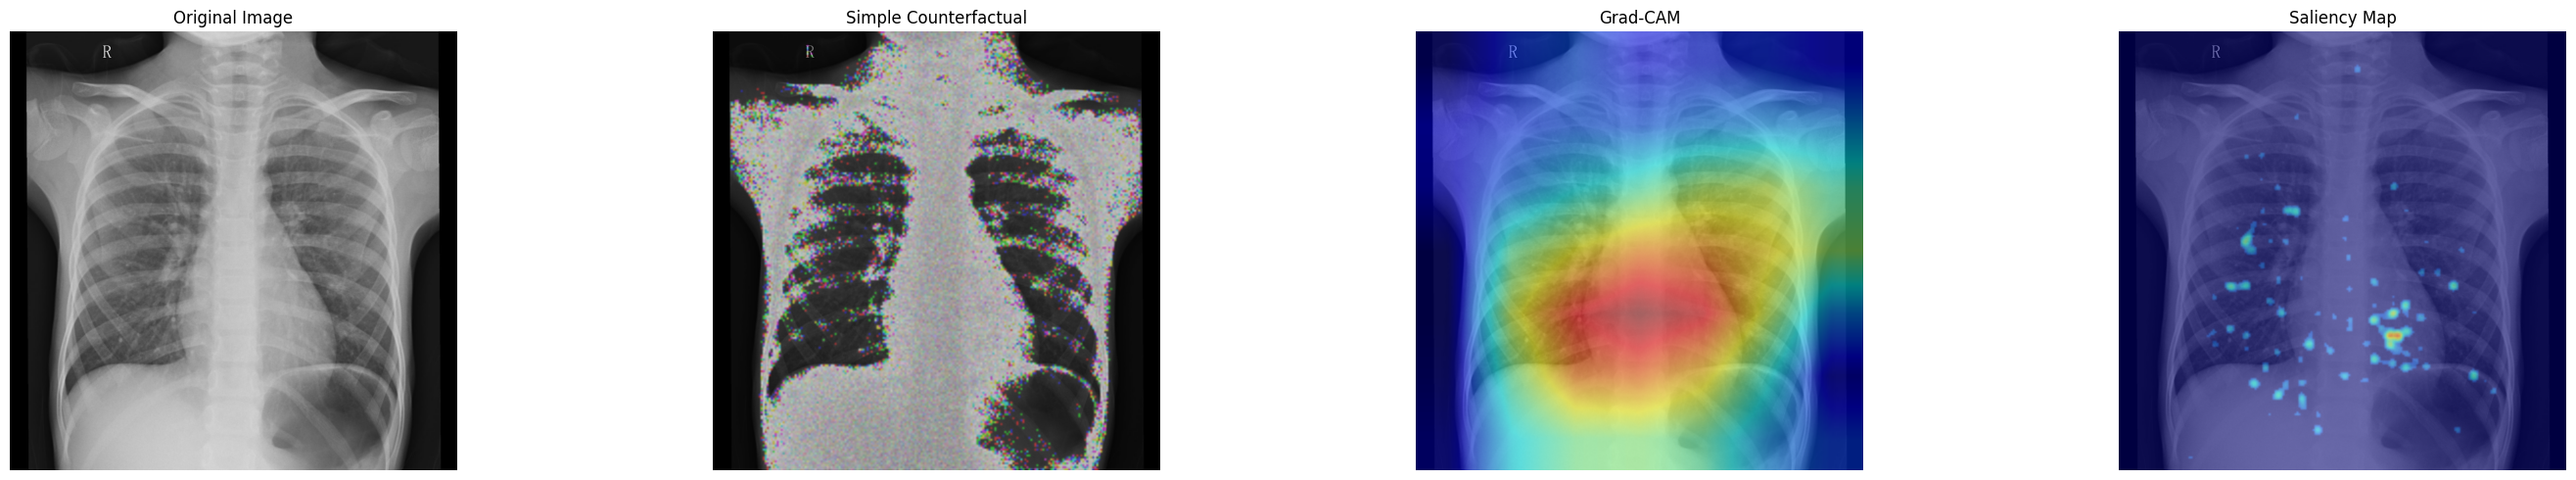

In [28]:
visualize_results('NORMAL2-IM-0107-0001.jpeg', model, model.layer4[2])

Prediction: Pneumonia


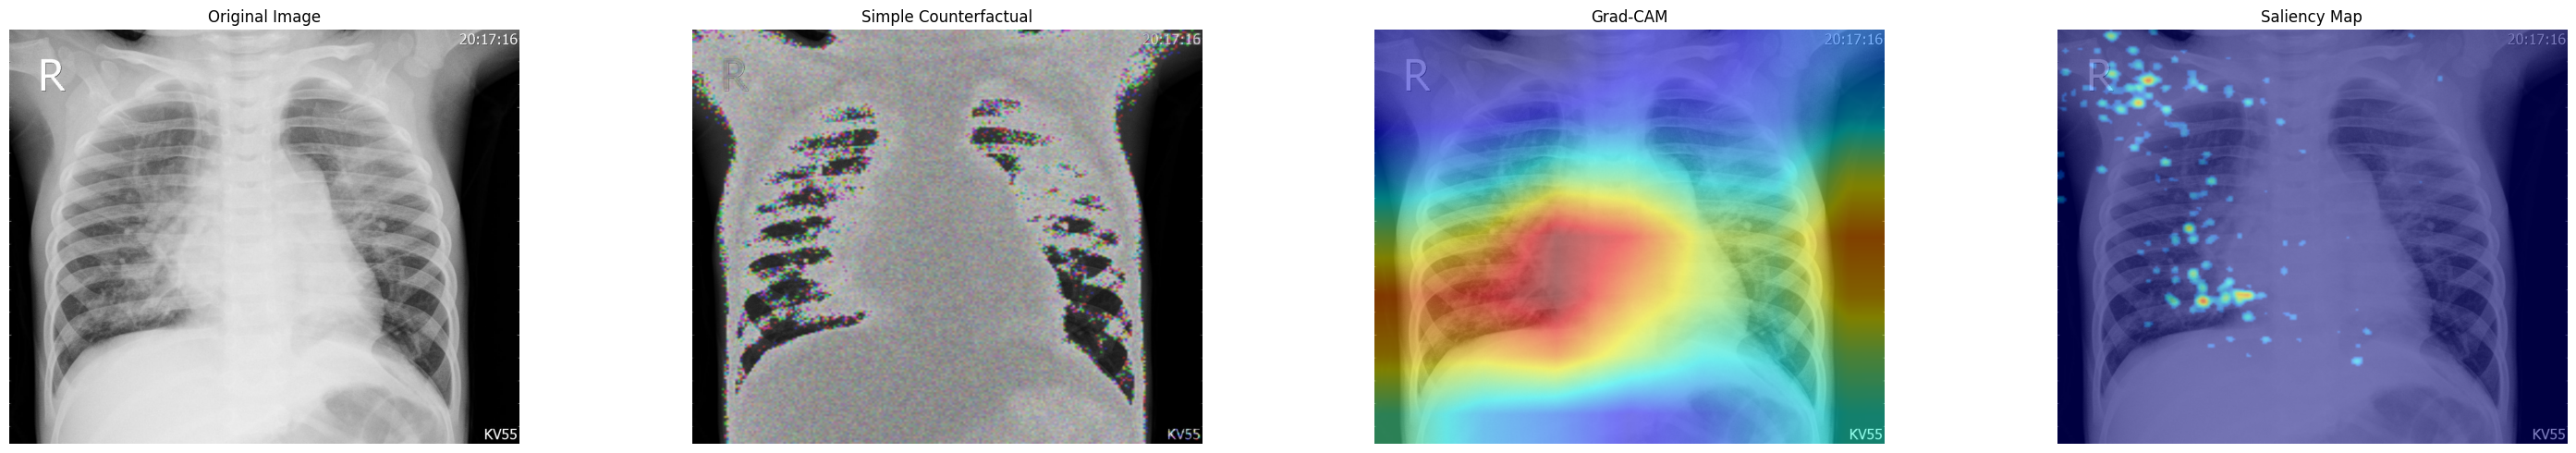

In [29]:
visualize_results('person38_virus_83.jpeg', model, model.layer4[2])